## Quantify similarity/divergence of human vs model=f(prompt)

Goal of Waerme und Wohnen Panel: understand the drivers and constraints for renovations to increase energy efficiency in Germany per socio-economic/demographic profile 
Goal of the thesis research: 
1. Reproduce hunan drivers/constraints for renovations in order to use the method for potential future pilot studies
2. If not possible to reproduce results identify and quantify the biases as well as potential solutions

### 1. Evaluate model decisions

The method aims to support pilot studies for policy design in the field of building decarbonization. 
From the three market failures presented in Singhal 2023:
* Externalities
    * What is the effect of internalizing the externality of CO2 emissions by carbon prices?
    * What is the effect of high volatility fossil fuel prices (high risk)
* Principal-Agent probelm
    * What is the effect of tenant/owner distribution of externalities and renovation costs
* **Credit Constraints**
    * **From those receiving subsidies, who are free raiders?** --> Always choose option B
    * **From those that do not perform a renovation, is it a budget constraint blocker? Who are them?** 
        * Hard limitations: Those that would only make the decision of complex renovation until 200 euros difference with simple (option 5)
        * Middle limitations: Those that would make the decision of complex renovation from 250-450 euros difference with simple (option 6-10) 
        * Mild limitations: Those that would make the decision of complex renovation from 500-900 euros difference with simple (option 11-14) 
    * What kind of errors will have a high penalty in policy design?
        * Consider free-raiders as price elastic citizens --> Diminish free-raider false negatives (recall): those that are predicted as something else but are free raiders so will get funding when they should not
        * Consider price elastic citizens as never-takers --> Diminish never-takers false negatives (recall): those that are predicted as compliers when are never-takers so have access to funding that wont be used

### 2. Quantify Bias
1. Do the models reproduce the human decisions? NO
    * Confusion matrix metrics
2. Which factors explain the error?
    * Option A) Fit a log regression with relevant factors to understand what drives decisions in humans vs model=f(prompt)
    * Option B) Model the error difference between the human and GPT-4
    * Option C) Model the difference between the decision taken and the rational decision according to object financial benefits
        * Calculate the optimal decision according to a) costs of renovation, b) savings per renovation and c) the expected years living in the flat
        * Compare bias/error from rational decion between human and GPT-4
        * Compare bias/error between different GPT-4 prompts (and GPT-3.5)
3. Is the error different depending on the type of prompt or is it consistent so it depends on the model?
4. Is the error symmetric or asymmetric?

**Which kind of information do I need for option C?**
* Option C) What determines if a person makes rational or emotional decisions?
    * Education level --> affect the next ones
    * Life ownership
    * Nature conservation concern
    * Belief in energy efficiency
    * Political orientation
    * Income and wealth level --> affect the next one
    * Long-term profit oriented
* Option C) How do I define rational behavior?
    * The savings in energy over the planned years (case -2% price increase or worse case scenario) - renovation costs ==> Highest profit option at each question
    * Market value variation --> purchase according to the DIW study 
    * Fix values per individual
        * savings per renovation type x years in the house
        * market value variation per renovation type
        * renovation costs of simple renovation
    * Variable values per individual
        * Net Present Value (PAPER MIT) = Gain Market Value + savings=f(discount rate, years) - Renovation Costs
        * Gain Market Value (DIW report) =  β × (EPSoriginal − EPS) where β = 0.71 EUR/m2 for purchasing and 0.002 EUR/m2 for renting
    * Calculate rational decision according to the previous calculations
        * Keep the information of difference on NPV
        * Keep the information of difference on Renovation costs
        * Keep the information of where the transition between complex and simple should happen, if at all, from a rational perspective
        * Keep the information of where the transition between complex and simple happen, if at all, by the human and the algorithm
        * Calculate where should be the transition from complex to simple if any to maximize NPV in each decision
    * Regression on the decision
        * Quantify the difference between the optimal rational transition, if any, and the human/algorithm
            * Difference in NPV
            * Difference in renovation cost
        * Every decision could be attributed the 0/1 value for matching rational decision or not --> does not capture asymmetric behavior
        * Every decision could be attributed the actual difference on NPV between the rational option and the decision made --> does capture asymmetric behavior
            * Requires panel data analysis
        * One decision per individual rather than per question --> Difference between the optimal transition point by rational agent vs human/algorithm in terms of NPV diff
            * Does not require panel data analysis
        * Factors
            * Prostpect theory: loss adversion/risk preference
                * Long term benefit
                * Life handling
                * Altruism
                * Beliefs on energy efficiency
            * Socioeconomic factors
                * Political orientation
                * Income level/wealth level
                * Education level
                * Building type

In [405]:
import sys
sys.path.append("../../../")

import numpy as np
import pandas as pd

from scipy.stats import norm

from src.eval_utils.metric_calculator import ResultEvaluator, plot_class_recalls, plot_recall
from src.eval_utils.utility_calculator import DeltaNVP

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load results

In [407]:
final_columns = ['ea801', 'ea802', 'ea803', 'ea804', 'ea805', 'ea806', 'ea807', 'ea808', 'ea809', 'ea810', 'ea811', 
                 'ea812', 'ea813', 'ea814', 'ea815']
opportunity_cost = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 900, 1200]
# Generate dataframe for evaluation
socioeconomic_factors = ['total_income_level','is_high_wealth','high_education_level','altq','prof_status']
psychological_factors = ['pol_orientation','is_altruist','nature_level','ownership_level','profit_focus','ee_belief']
npv_factors = ['ist5','kdj','kde','kdu','ebj','ebe','ebu','a6']
columns_to_exclude_ols = ['success', 'label', 'temperature', 'decision', 'key', 
                      'citizen_type', 'profit_focus_long', 'profit_focus_short', 
                      'ownership_level_Medium', 'ownership_level_High', 
                      'nature_level_High', 'nature_level_Medium', 
                      'pol_orientation_left', 'pol_orientation_right', 
                      'pol_orientation_center', 'is_altruist']

df_sample = pd.read_csv("../../../data/ariadne/heating_buildings/df_cata_completed_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')
df_questions = pd.read_csv("../../../data/ariadne/heating_buildings/questions_selected_survey_mapper_encoded.csv", sep=';', encoding='utf-8', on_bad_lines='skip')
df_sel_complete_pol_ta_clean = pd.read_csv("../../../data/ariadne/heating_buildings/df_cata_completed_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')

# Load results for GPT-4
# 1. GPT-4 non-emotional - Ta: 0.1, 0.3, 0.5
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_2053/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
df_synthetic_4_n_emotional_0_1 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_2113/recurrent_gpt-4-1106-preview-t_0.3_qa.csv'
df_synthetic_4_n_emotional_0_3 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_2121/recurrent_gpt-4-1106-preview-t_0.5_qa.csv'
df_synthetic_4_n_emotional_0_5 = pd.read_csv(output_file)

# 2. GPT-4 emotional - Ta: 0.1, 0.5, 0.6
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0140/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
df_synthetic_4_emotional_0_1 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0158/recurrent_gpt-4-1106-preview-t_0.5_qa.csv'
df_synthetic_4_emotional_0_5 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0219/recurrent_gpt-4-1106-preview-t_0.6_qa.csv'
df_synthetic_4_emotional_0_6 = pd.read_csv(output_file)

# 3. GPT-4 logic - Ta: 0.1, 0.3, 0.5
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_1142/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
df_synthetic_4_logic_0_1 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_1150/recurrent_gpt-4-1106-preview-t_0.3_qa.csv'
df_synthetic_4_logic_0_3 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_1306/recurrent_gpt-4-1106-preview-t_0.5_qa.csv'
df_synthetic_4_logic_0_5 = pd.read_csv(output_file)

# 4. GPT-4 personalized - Ta: 0.1, 0.3, 0.5
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_2040/recurrent_gpt-4-1106-preview-t_0.1_qa.csv'
df_synthetic_4_personal_0_1 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_2025/recurrent_gpt-4-1106-preview-t_0.3_qa.csv'
df_synthetic_4_personal_0_3 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_2031/recurrent_gpt-4-1106-preview-t_0.5_qa.csv'
df_synthetic_4_personal_0_5 = pd.read_csv(output_file)

# Load results for GPT-3.5
# 1. GPT-3.5 non-emotional - Ta: 0.1, 0.3, 0.5
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_1005/recurrent_gpt-3.5-turbo-t_0.1_qa.csv'
df_synthetic_3_5_n_emotional_0_1 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0923/recurrent_gpt-3.5-turbo-t_0.3_qa.csv'
df_synthetic_3_5_n_emotional_0_3 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0936/recurrent_gpt-3.5-turbo-t_0.5_qa.csv'
df_synthetic_3_5_n_emotional_0_5 = pd.read_csv(output_file)

# 2. GPT-3.5 emotional - Ta: 0.1, 0.3, 0.5, 0.6
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0253/recurrent_gpt-3.5-turbo-t_0.1_qa.csv'
df_synthetic_3_5_emotional_0_1 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0309/recurrent_gpt-3.5-turbo-t_0.3_qa.csv'
df_synthetic_3_5_emotional_0_3 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0322/recurrent_gpt-3.5-turbo-t_0.5_qa.csv'
df_synthetic_3_5_emotional_0_5 = pd.read_csv(output_file)
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240104_0335/recurrent_gpt-3.5-turbo-t_0.6_qa.csv'
df_synthetic_3_5_emotional_0_6 = pd.read_csv(output_file)

### 2. Calculate model performance by prompt strategy and temperature

#### 2.1. Calculate confusion matrices

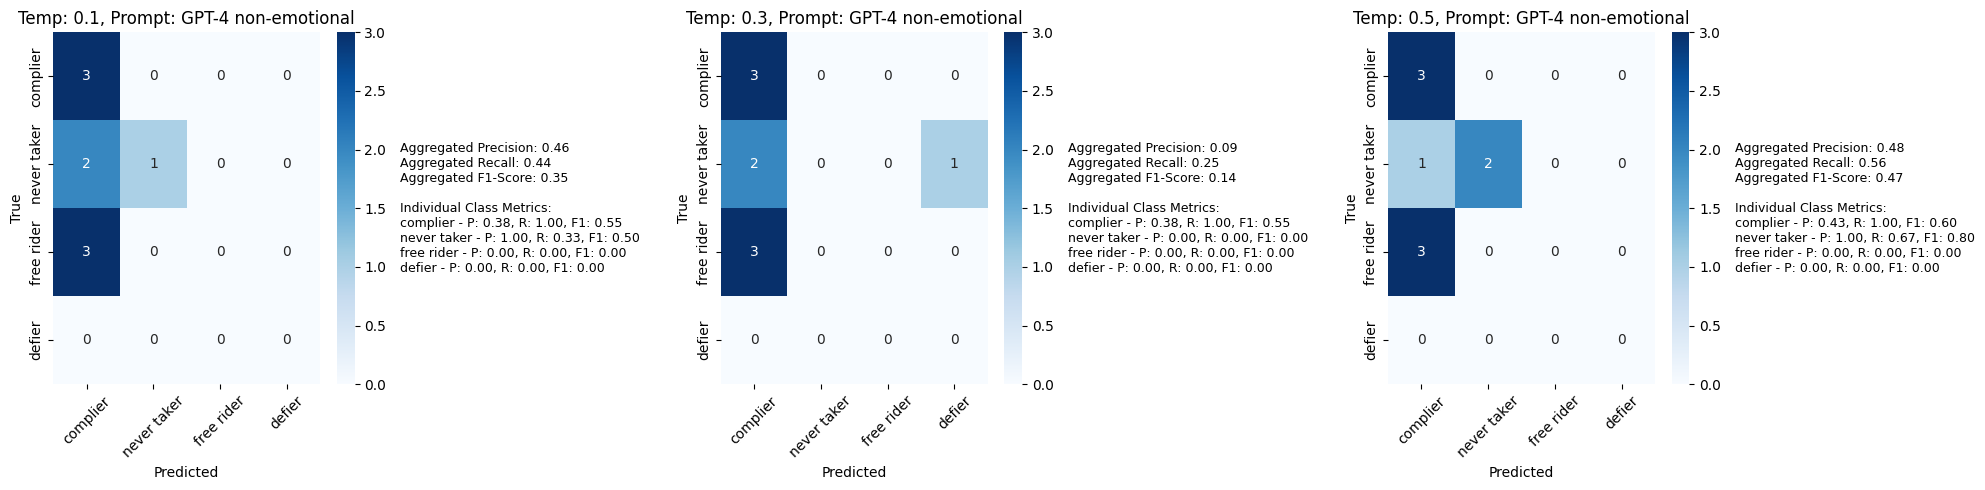

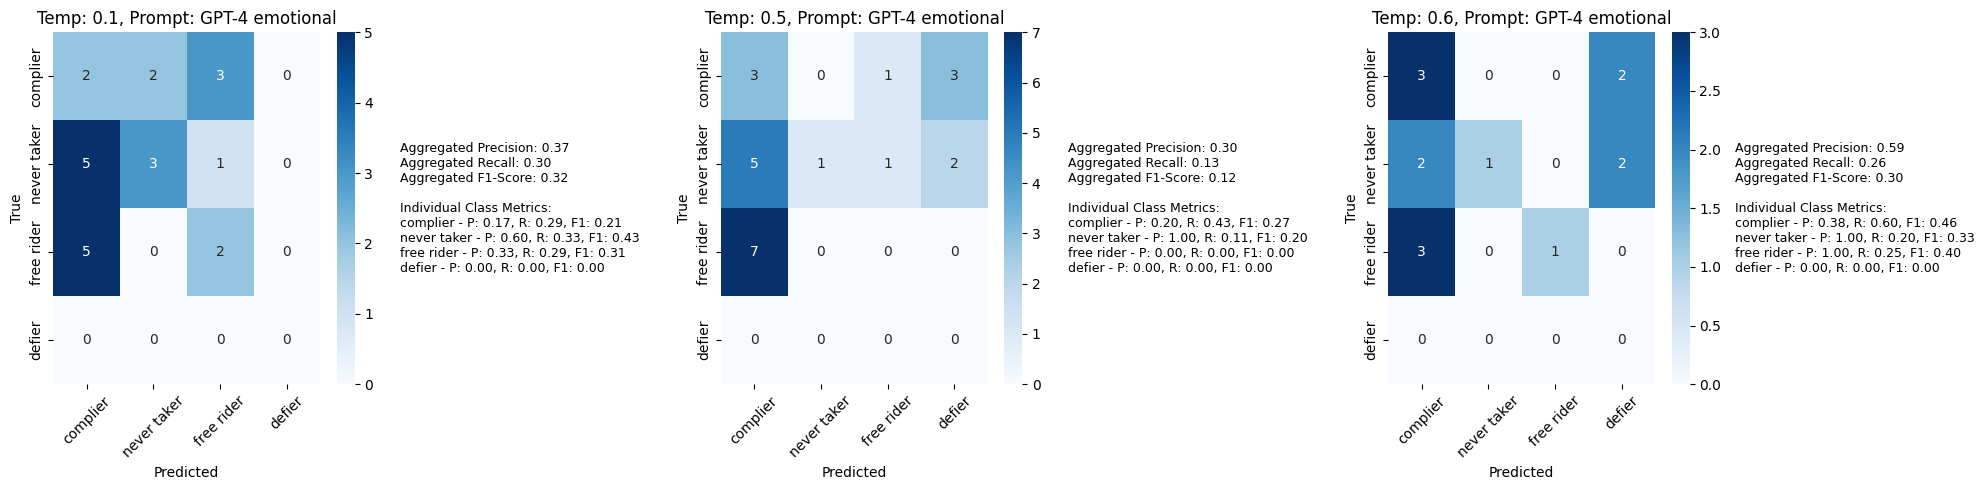

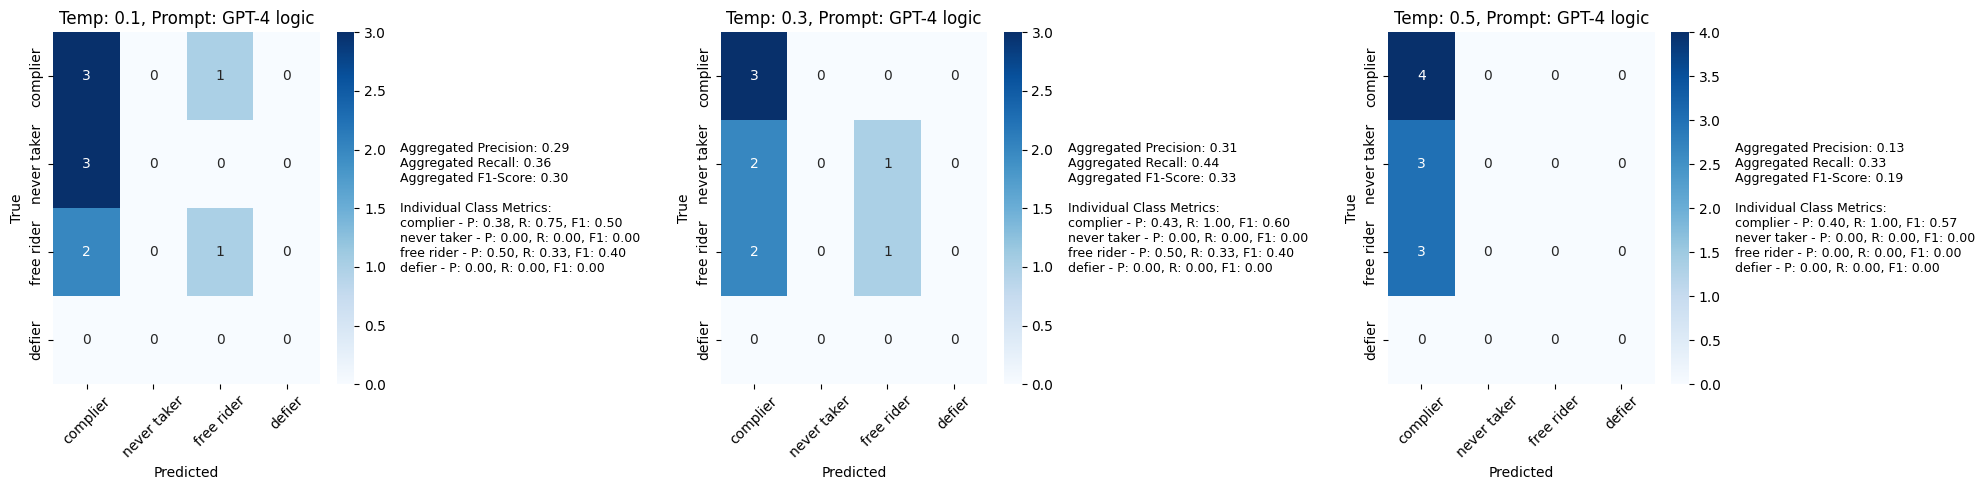

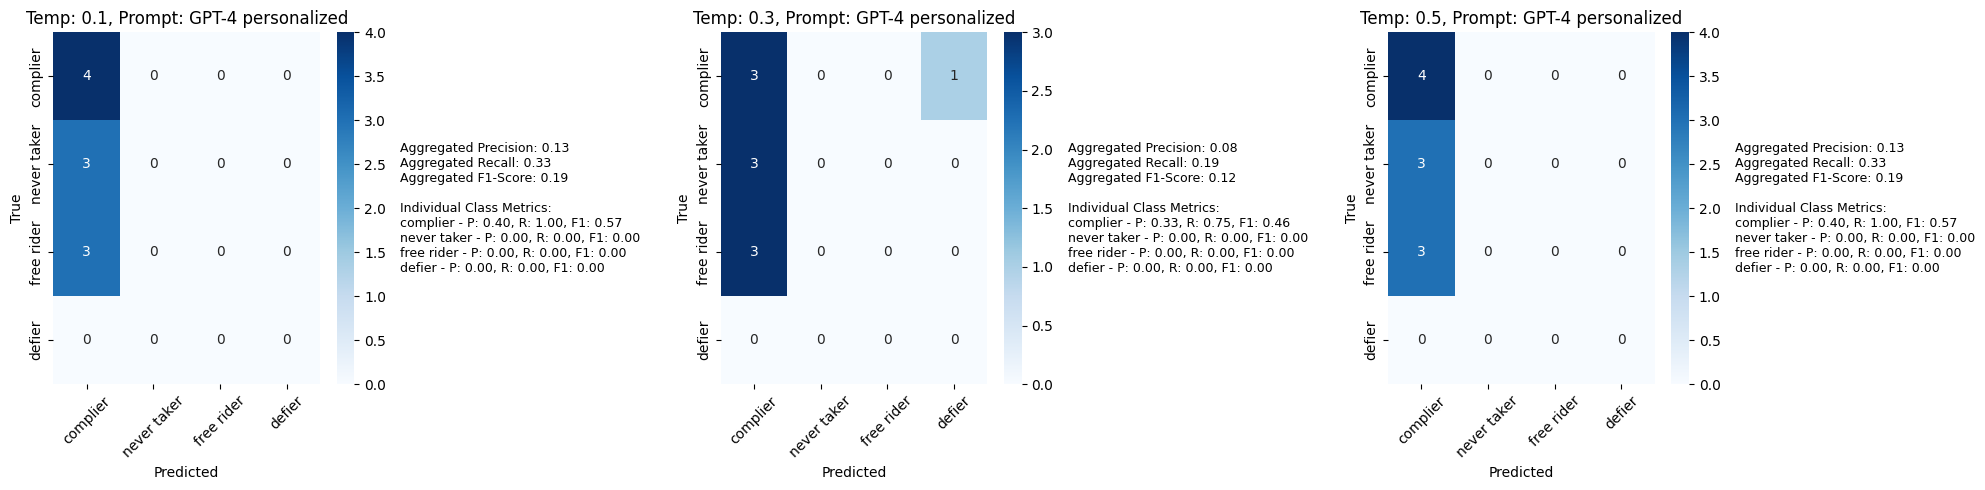

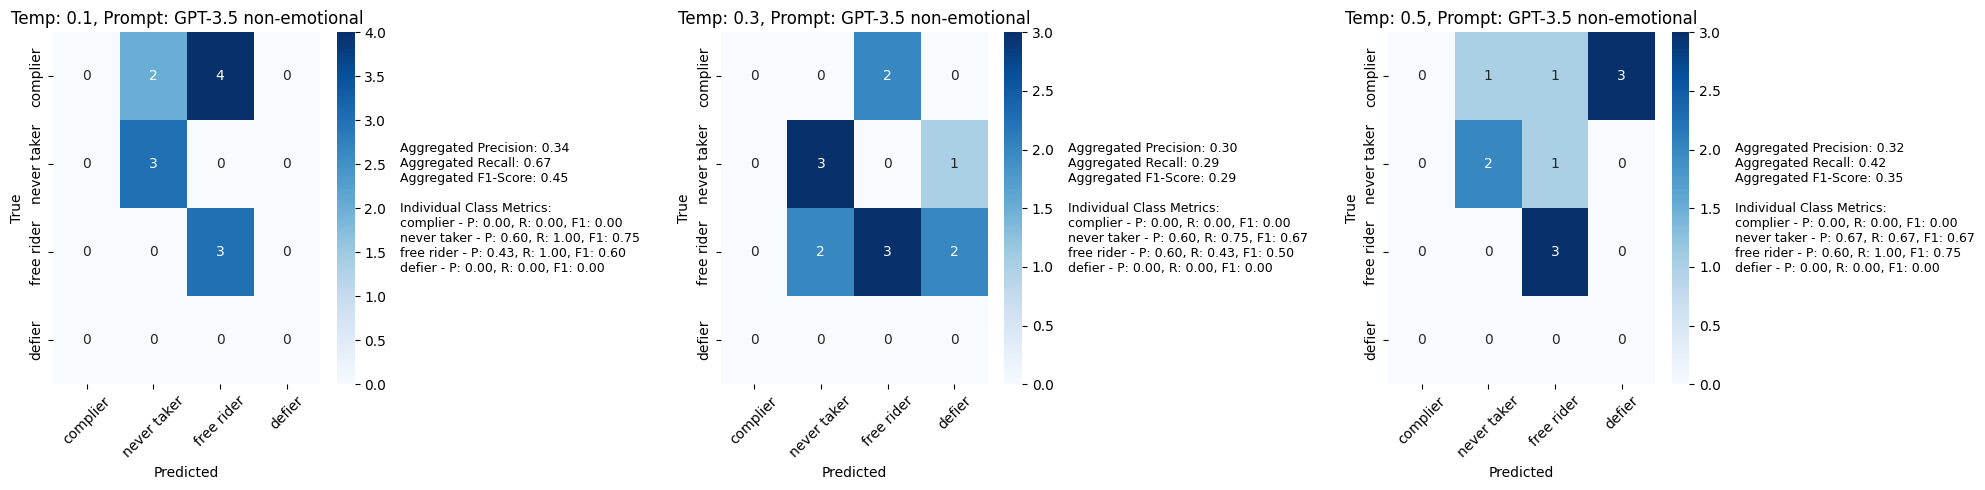

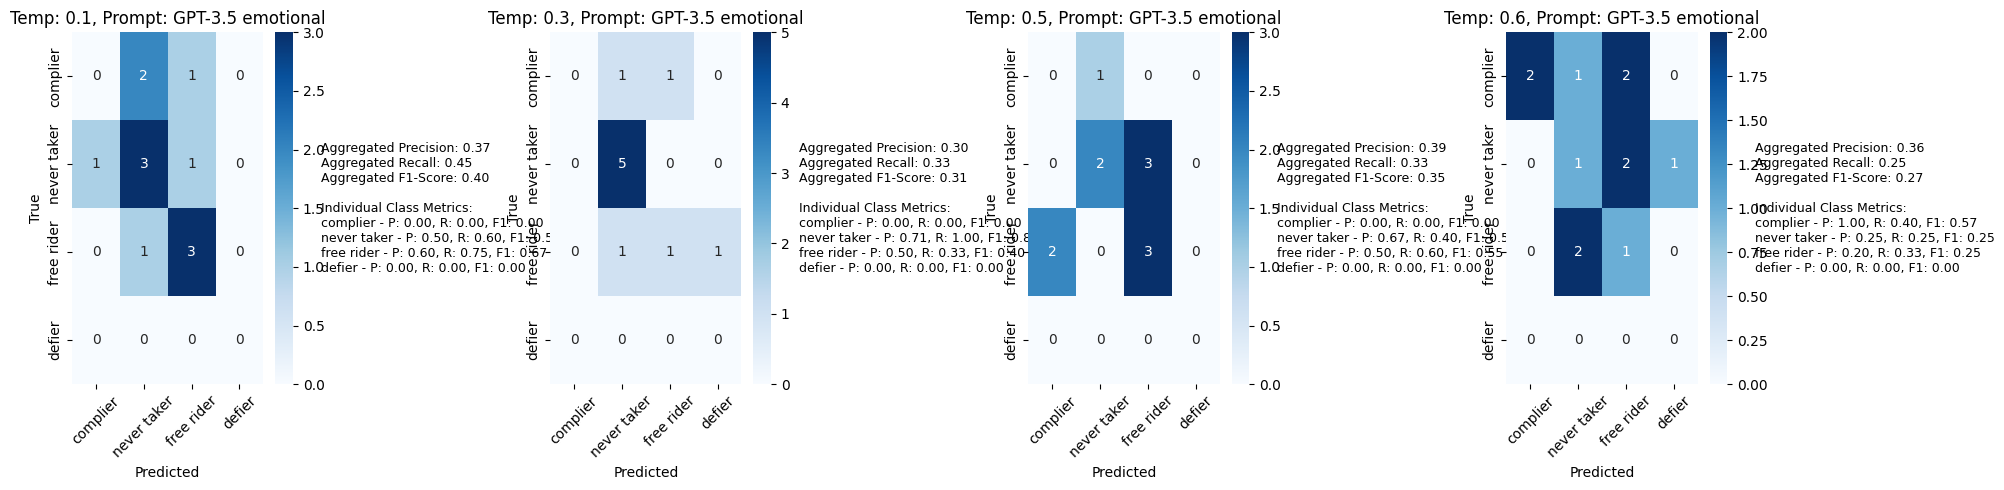

In [408]:
metrics = []
n_bootstraps = 5
evaluator = ResultEvaluator(final_columns=final_columns, opportunity_costs=opportunity_cost)
df_metrics, df_sample_sel_4_n_emotional, df_synthetic_4_n_emotional = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_4_n_emotional_0_1, df_synthetic_4_n_emotional_0_3, df_synthetic_4_n_emotional_0_5], 
                                ['complier', 'never taker', 'free rider','defier'], [0.1, 0.3, 0.5], 'GPT-4 non-emotional', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)
df_metrics, df_sample_sel_4_emotional, df_synthetic_4_emotional = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_4_emotional_0_1, df_synthetic_4_emotional_0_5, df_synthetic_4_emotional_0_6], 
                                ['complier', 'never taker', 'free rider','defier'], [0.1, 0.5, 0.6], 'GPT-4 emotional', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)
df_metrics, df_sample_sel_4_logic, df_synthetic_4_logic = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_4_logic_0_1, df_synthetic_4_logic_0_3, df_synthetic_4_logic_0_5], 
                                ['complier', 'never taker', 'free rider','defier'], [0.1, 0.3, 0.5], 'GPT-4 logic', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)
df_metrics, df_sample_sel_personal, df_synthetic_personal = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_4_personal_0_1, df_synthetic_4_personal_0_3, df_synthetic_4_personal_0_5], 
                                ['complier', 'never taker', 'free rider','defier'], [0.1, 0.3, 0.5], 'GPT-4 personalized', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)
df_metrics, df_sample_sel_3_5_n_emotional, df_synthetic_3_5_n_emotional = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_3_5_n_emotional_0_1, df_synthetic_3_5_n_emotional_0_3, df_synthetic_3_5_n_emotional_0_5], 
                                ['complier', 'never taker', 'free rider','defier'], [0.1, 0.3, 0.5], 'GPT-3.5 non-emotional', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)
df_metrics, df_sample_sel_3_5_emotional, df_synthetic_3_5_emotional = evaluator.collect_metrics_across_conditions(df_sample, [df_synthetic_3_5_emotional_0_1, df_synthetic_3_5_emotional_0_3, df_synthetic_3_5_emotional_0_5, df_synthetic_3_5_emotional_0_6], 
                                ['complier', 'never taker', 'free rider','defier'], [0.1, 0.3, 0.5, 0.6], 'GPT-3.5 emotional', socioeconomic_factors, psychological_factors+npv_factors, n_bootstraps)
metrics.append(df_metrics)

#### 2.1. Calculate bootstrapped recall for key classes

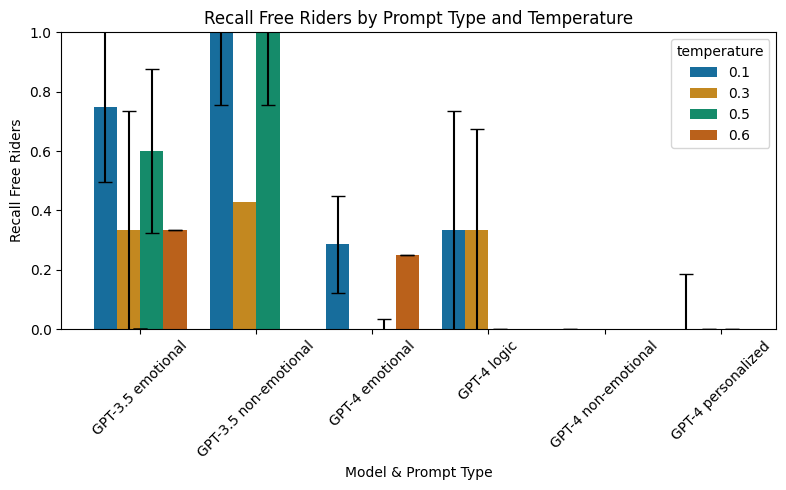

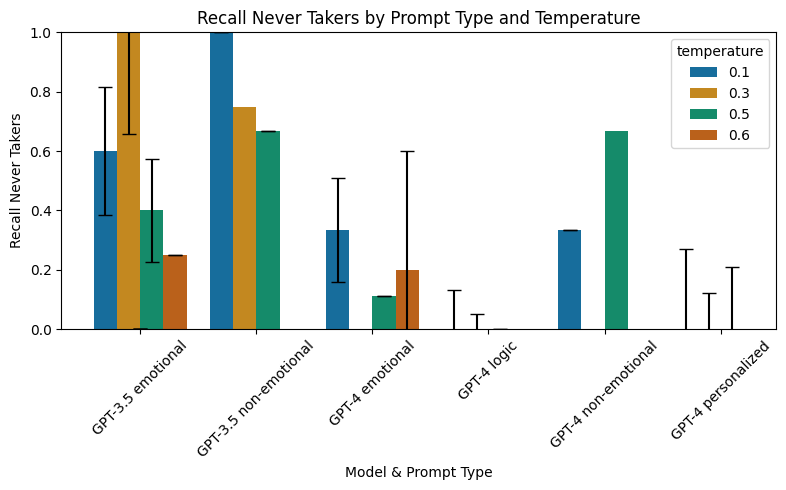

In [409]:
df_metrics = pd.concat(metrics)
df_ = plot_class_recalls(df_metrics)
plot_recall(df_, recall_type='recall_free_riders')
plot_recall(df_, recall_type='recall_never_takers')

### 3. Compare Objective vs Subjective Utilities per Model/Prompt/Temperature

#### 3.1. Human Objective vs Subjective utility

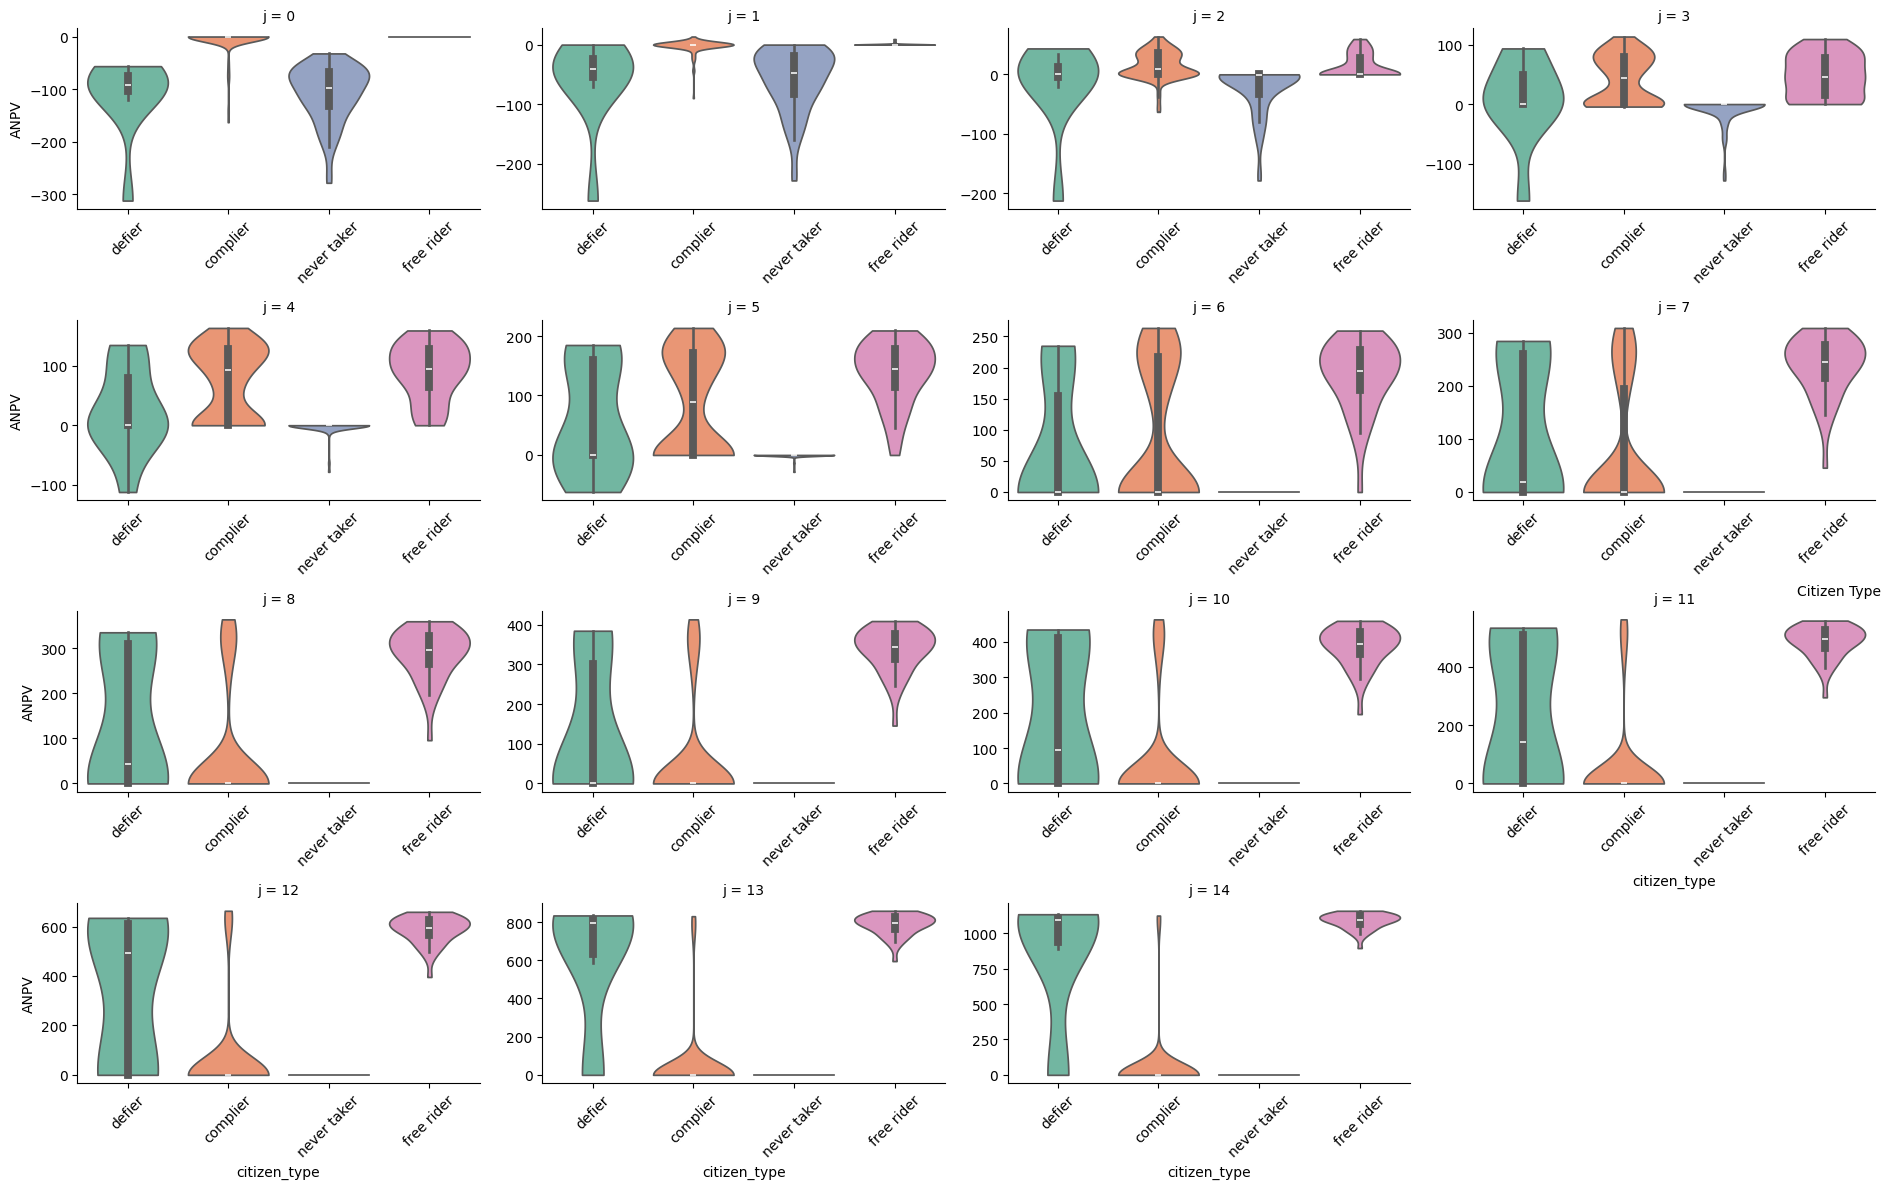

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     129.7
Date:                Mon, 08 Jan 2024   Prob (F-statistic):          5.71e-103
Time:                        21:15:53   Log-Likelihood:                -4420.0
No. Observations:                3285   AIC:                             8850.
Df Residuals:                    3280   BIC:                             8880.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [410]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
calculator = DeltaNVP(discount_rate=1.128)
df_relevant = df_sample[df_sample['citizen_type']!='unknown']
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
independent_variables = ['is_nature_protector']
summary, merged_df_human = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


#### 3.2. GPT-4 + Emotional prompt + Temp 0.1: Objective vs Subjective utility

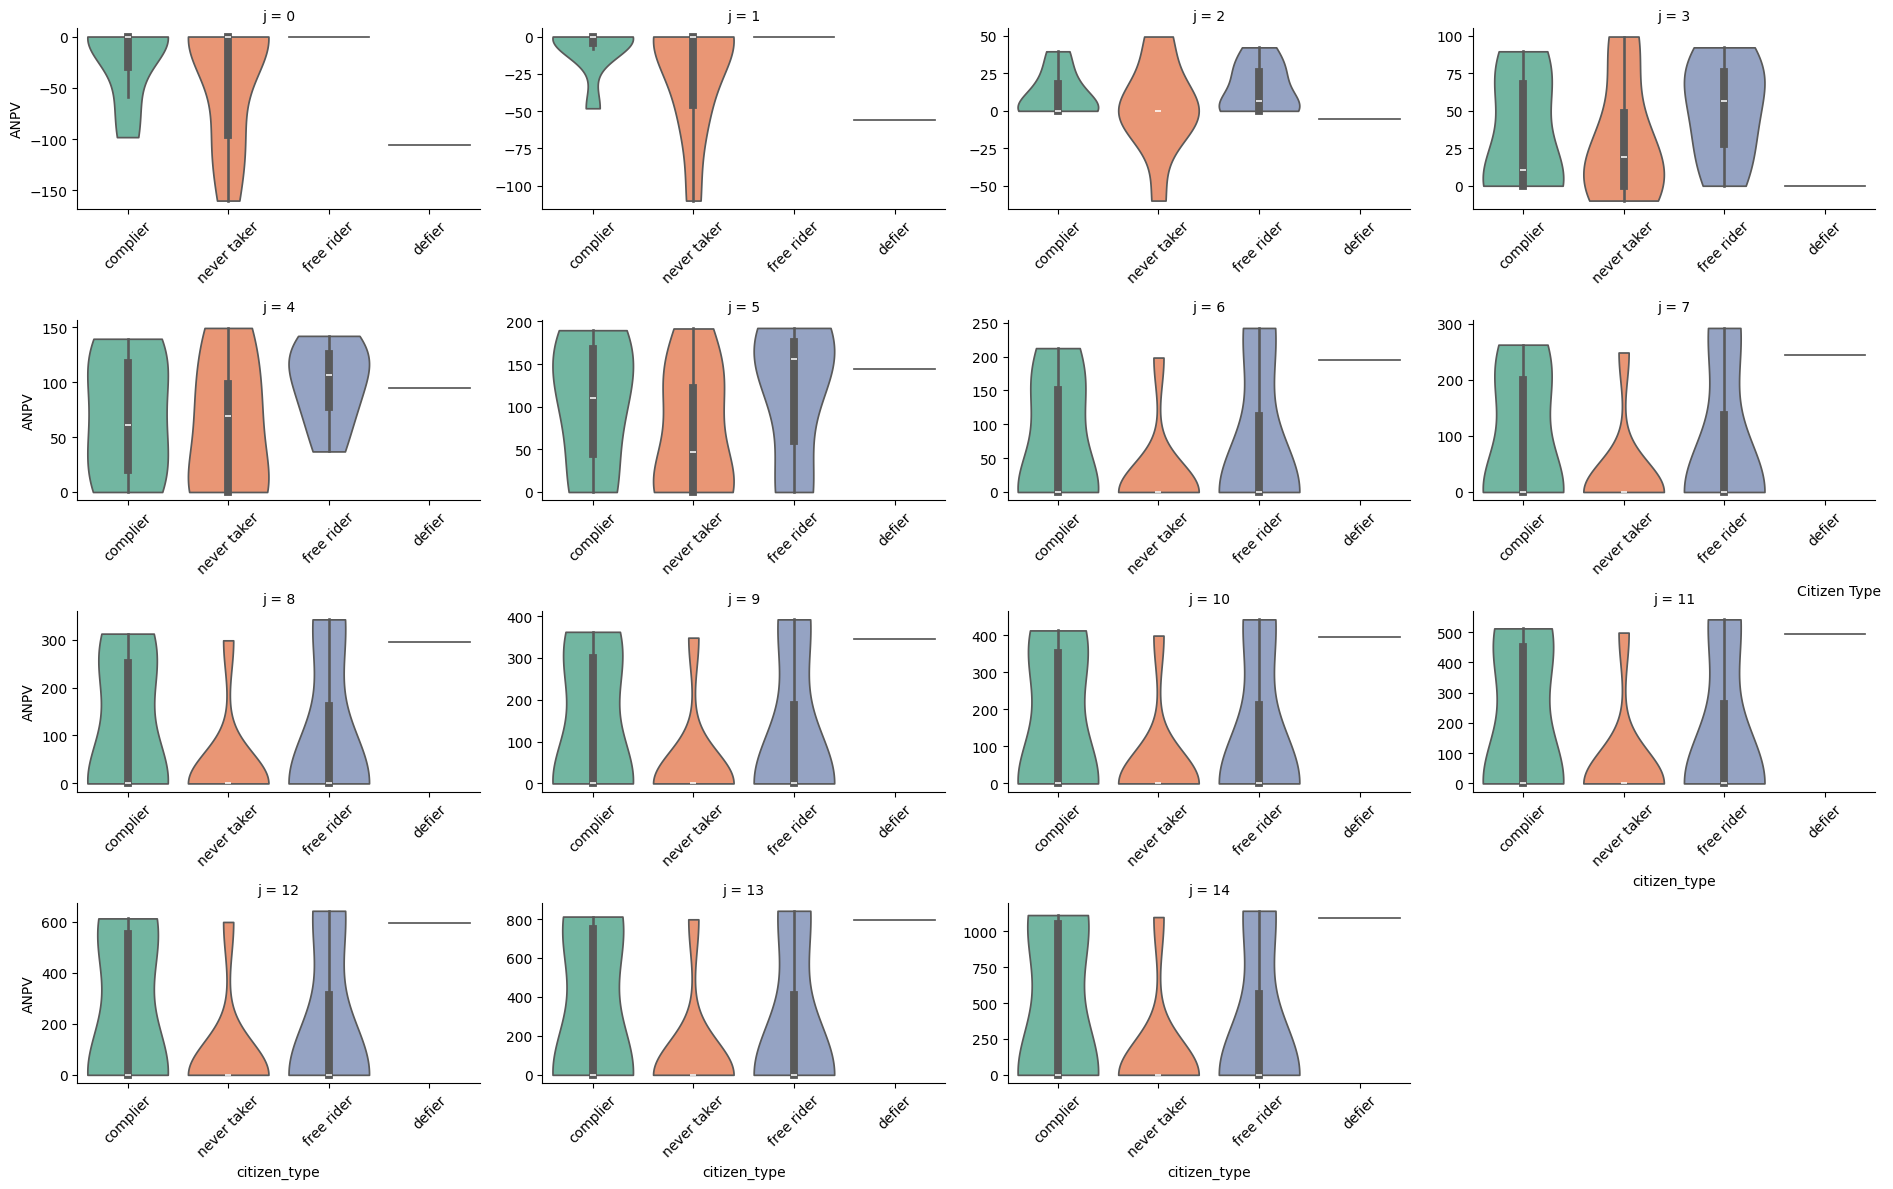

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     27.33
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           6.27e-16
Time:                        21:16:01   Log-Likelihood:                -473.51
No. Observations:                 360   AIC:                             955.0
Df Residuals:                     356   BIC:                             970.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [411]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_4_emotional_0_1['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_4_emotional_0_1[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_emo_gpt4 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


#### 3.3. GPT-4 + Non-Emotional prompt + Temp 0.5: Objective vs Subjective utility

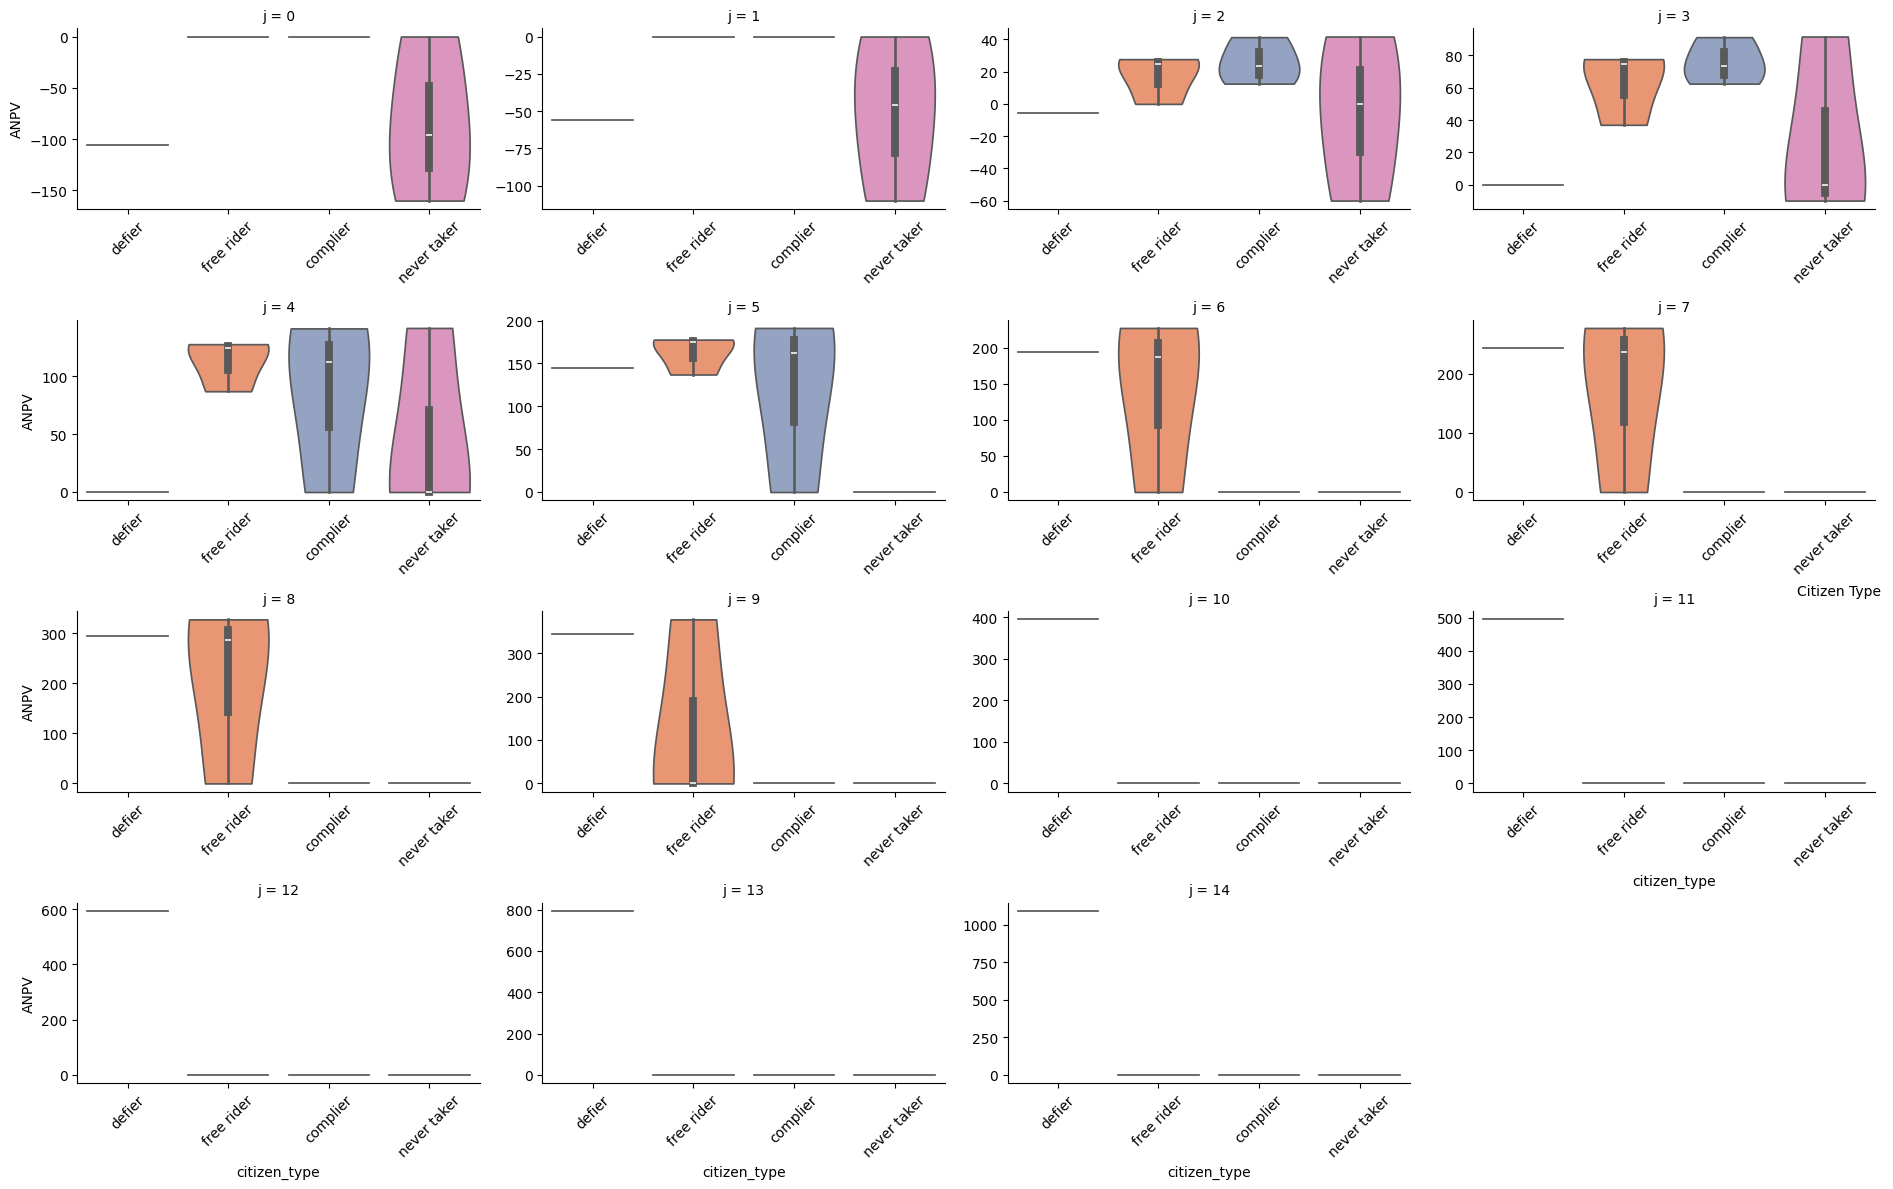

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     15.97
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           4.94e-09
Time:                        21:16:08   Log-Likelihood:                -191.56
No. Observations:                 150   AIC:                             391.1
Df Residuals:                     146   BIC:                             403.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [412]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_4_n_emotional_0_5['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_4_n_emotional_0_5[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_n_emo_gpt4 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


#### 3.4. GPT-4 + Logic prompt + Temp 0.3: Objective vs Subjective utility

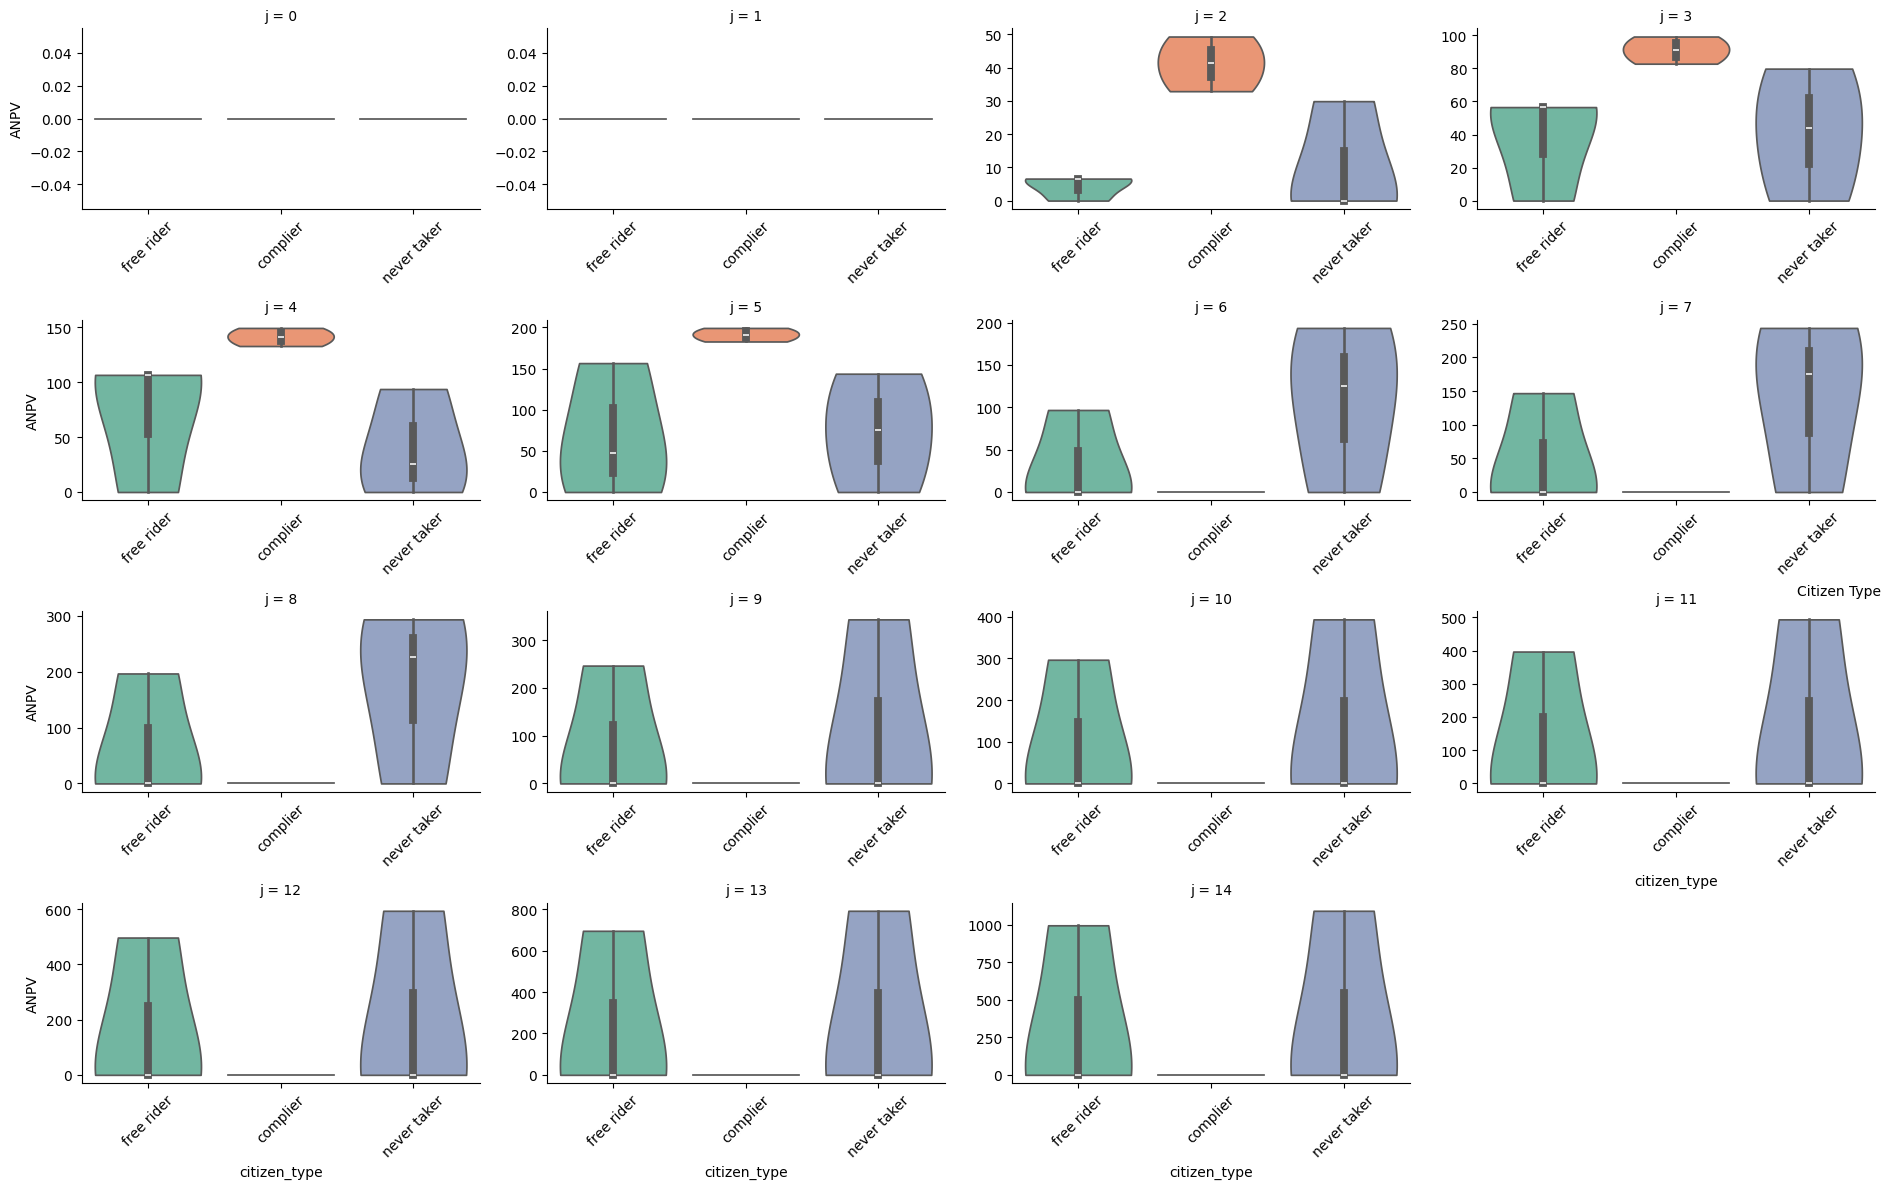

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     48.92
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           2.82e-21
Time:                        21:16:15   Log-Likelihood:                -140.83
No. Observations:                 135   AIC:                             289.7
Df Residuals:                     131   BIC:                             301.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [413]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_4_logic_0_3['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_4_logic_0_3[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_log_gpt4 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


#### 3.5. GPT-4 + Personalized prompt + Temp 0.1: Objective vs Subjective utility

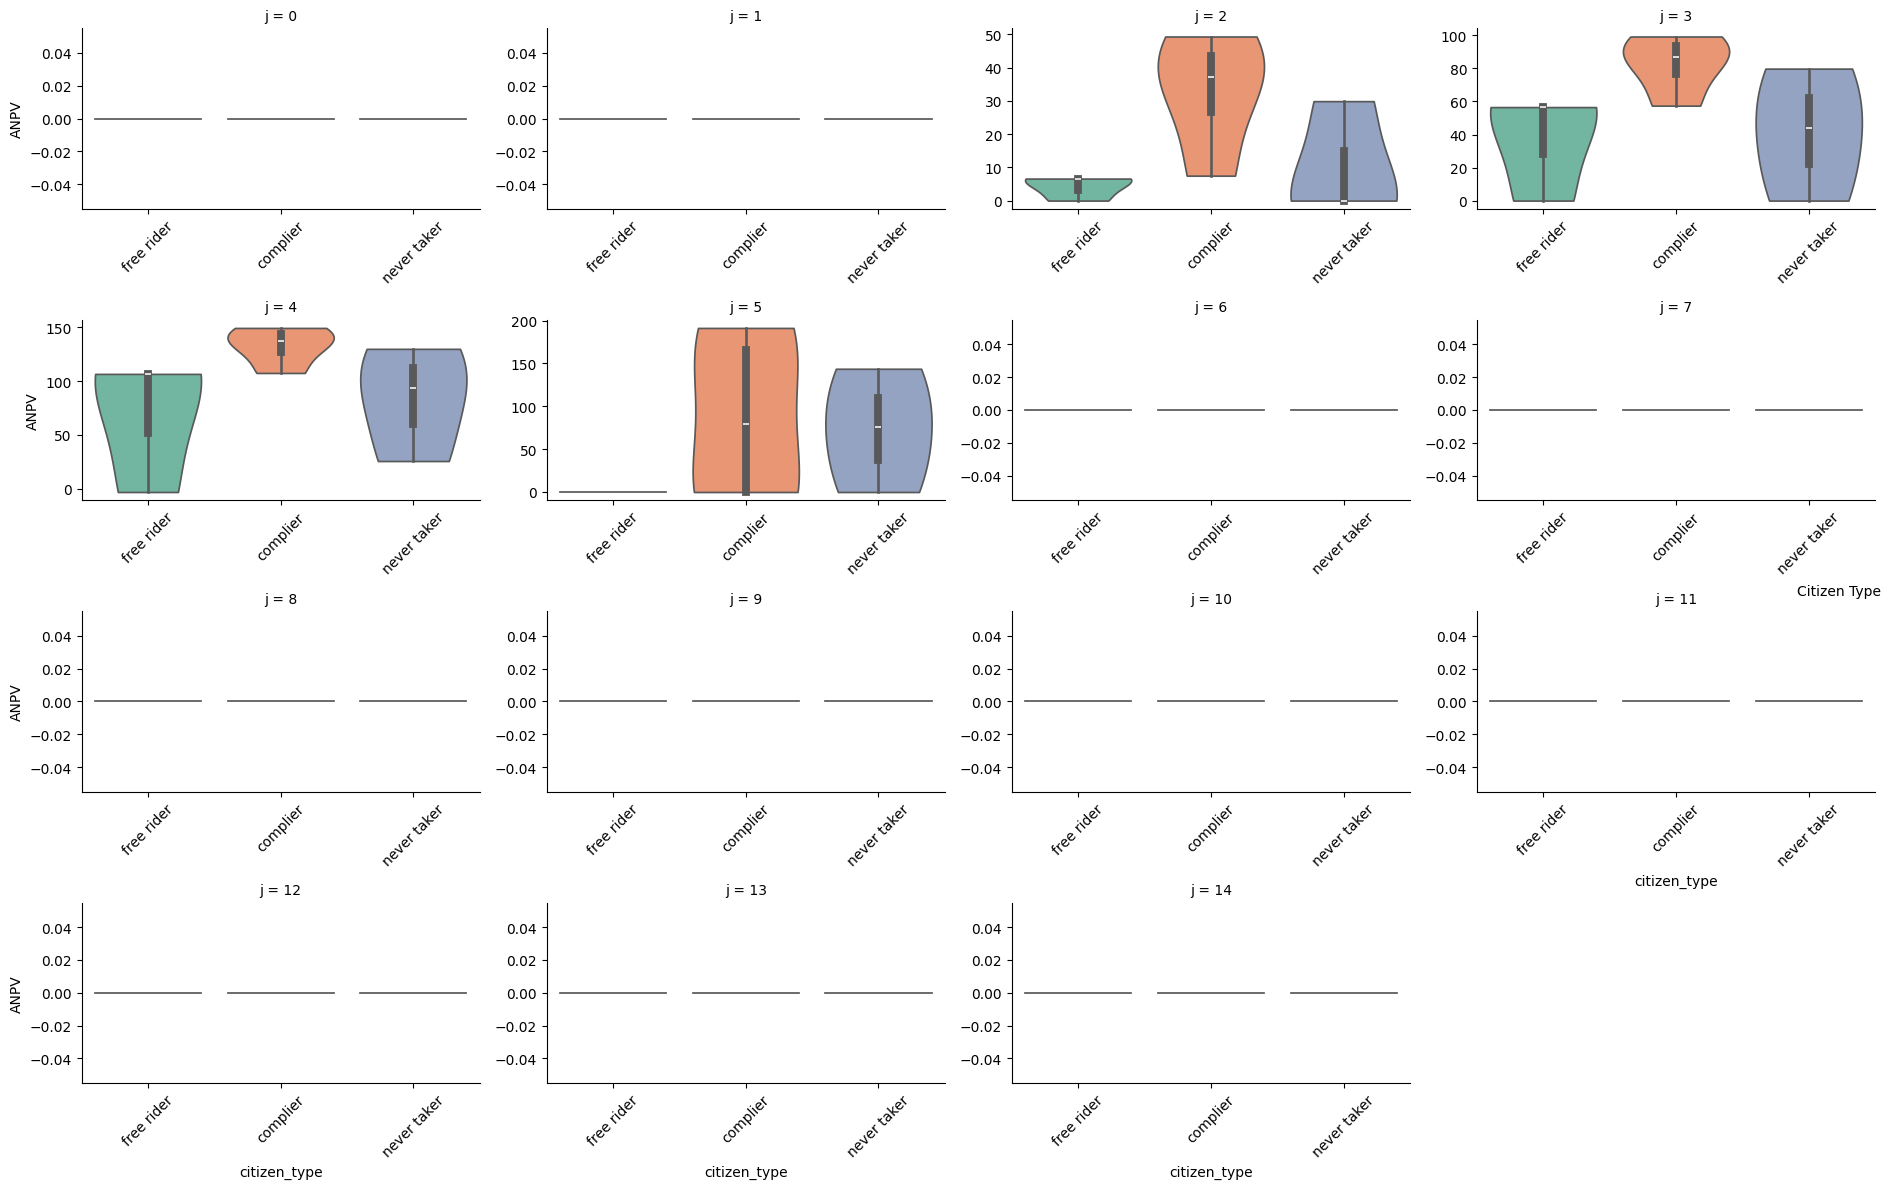

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     3.939
Date:                Mon, 08 Jan 2024   Prob (F-statistic):            0.00974
Time:                        21:16:23   Log-Likelihood:                -207.00
No. Observations:                 150   AIC:                             422.0
Df Residuals:                     146   BIC:                             434.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [414]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_4_personal_0_1['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_4_personal_0_1[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_pers_gpt4 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


#### 3.6. GPT-3.5-turbo + Emotional prompt + Temp 0.1: Objective vs Subjective utility

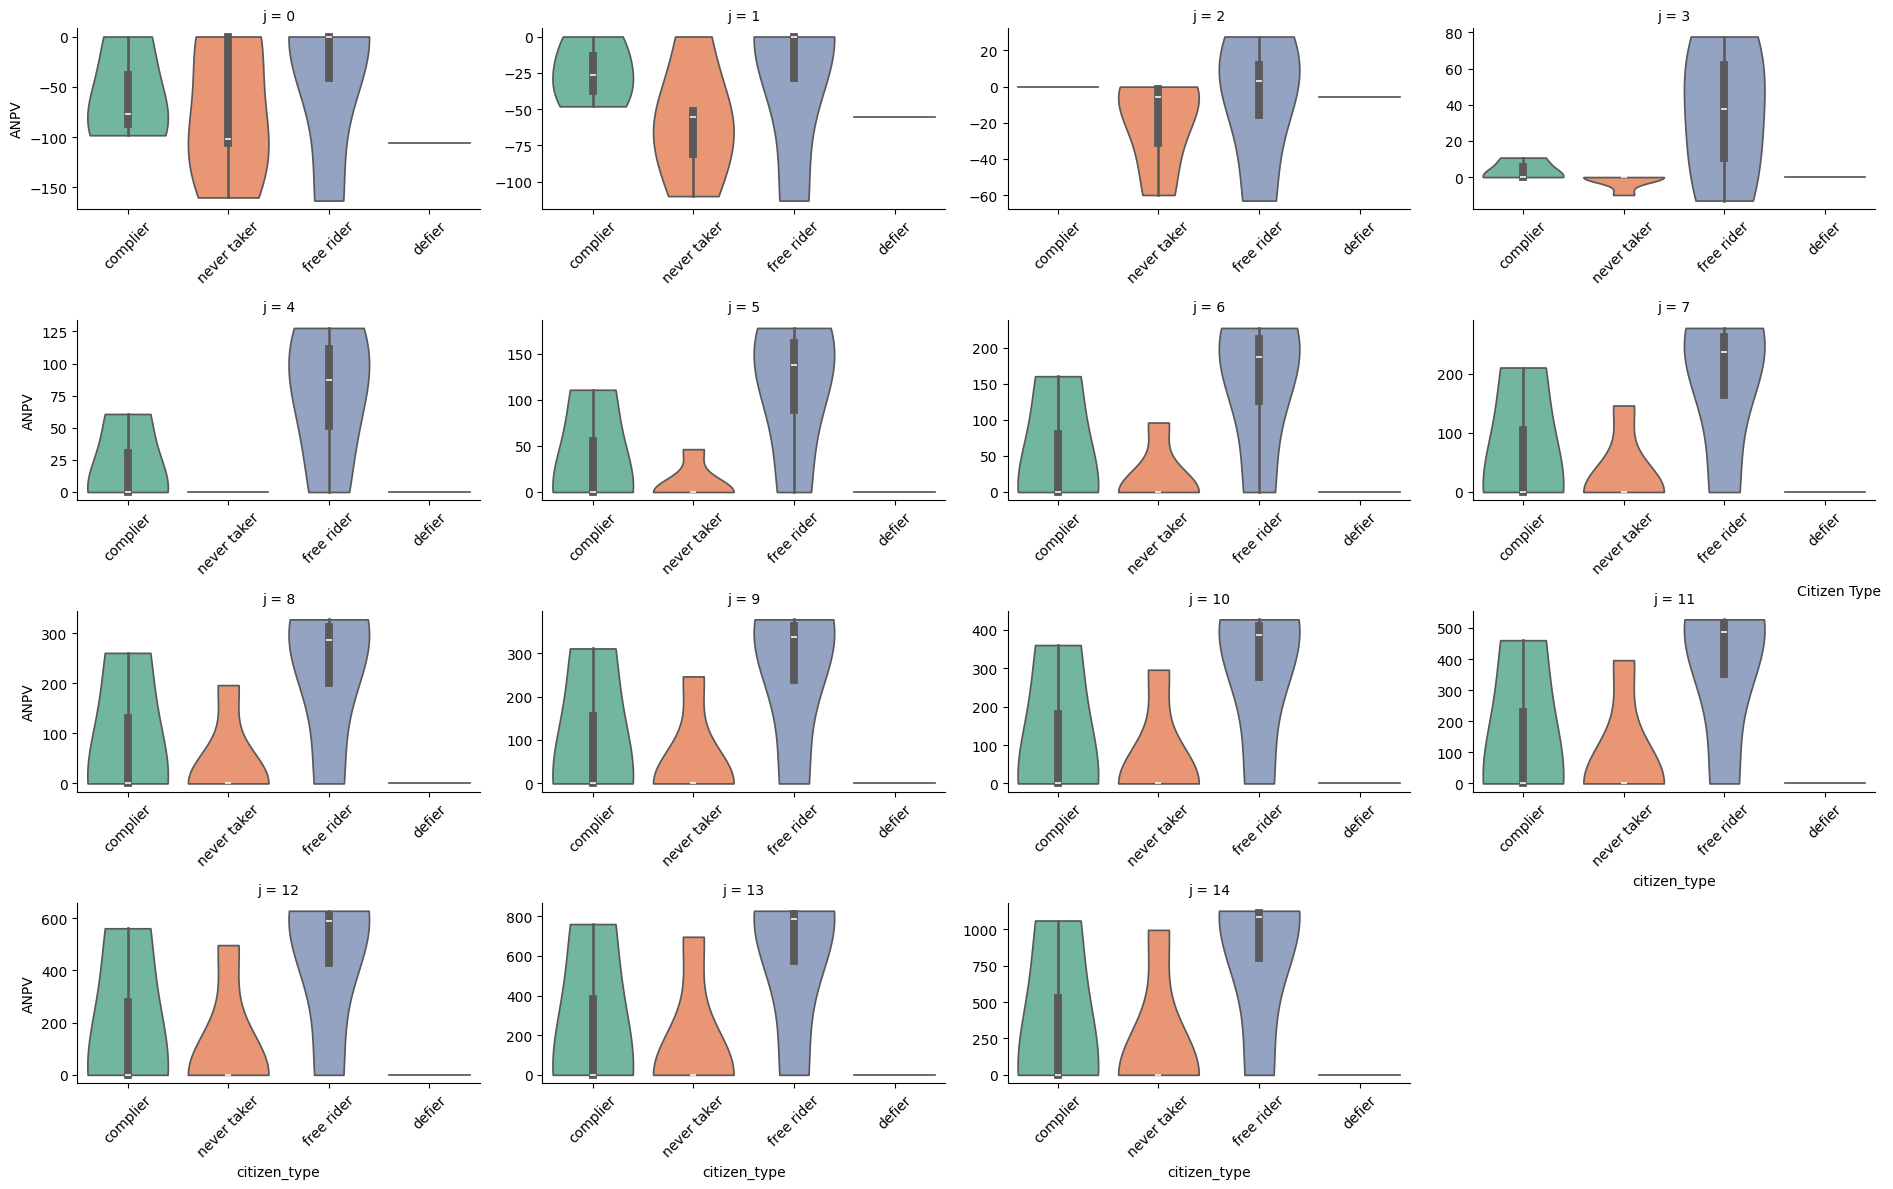

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     41.15
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           1.47e-20
Time:                        21:16:31   Log-Likelihood:                -228.08
No. Observations:                 195   AIC:                             464.2
Df Residuals:                     191   BIC:                             477.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [415]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_3_5_emotional_0_1['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_3_5_emotional_0_1[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_emo_gpt35 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


#### 3.7. GPT-3.5-turbo + Non-Emotional prompt + Temp 0.1: Objective vs Subjective utility

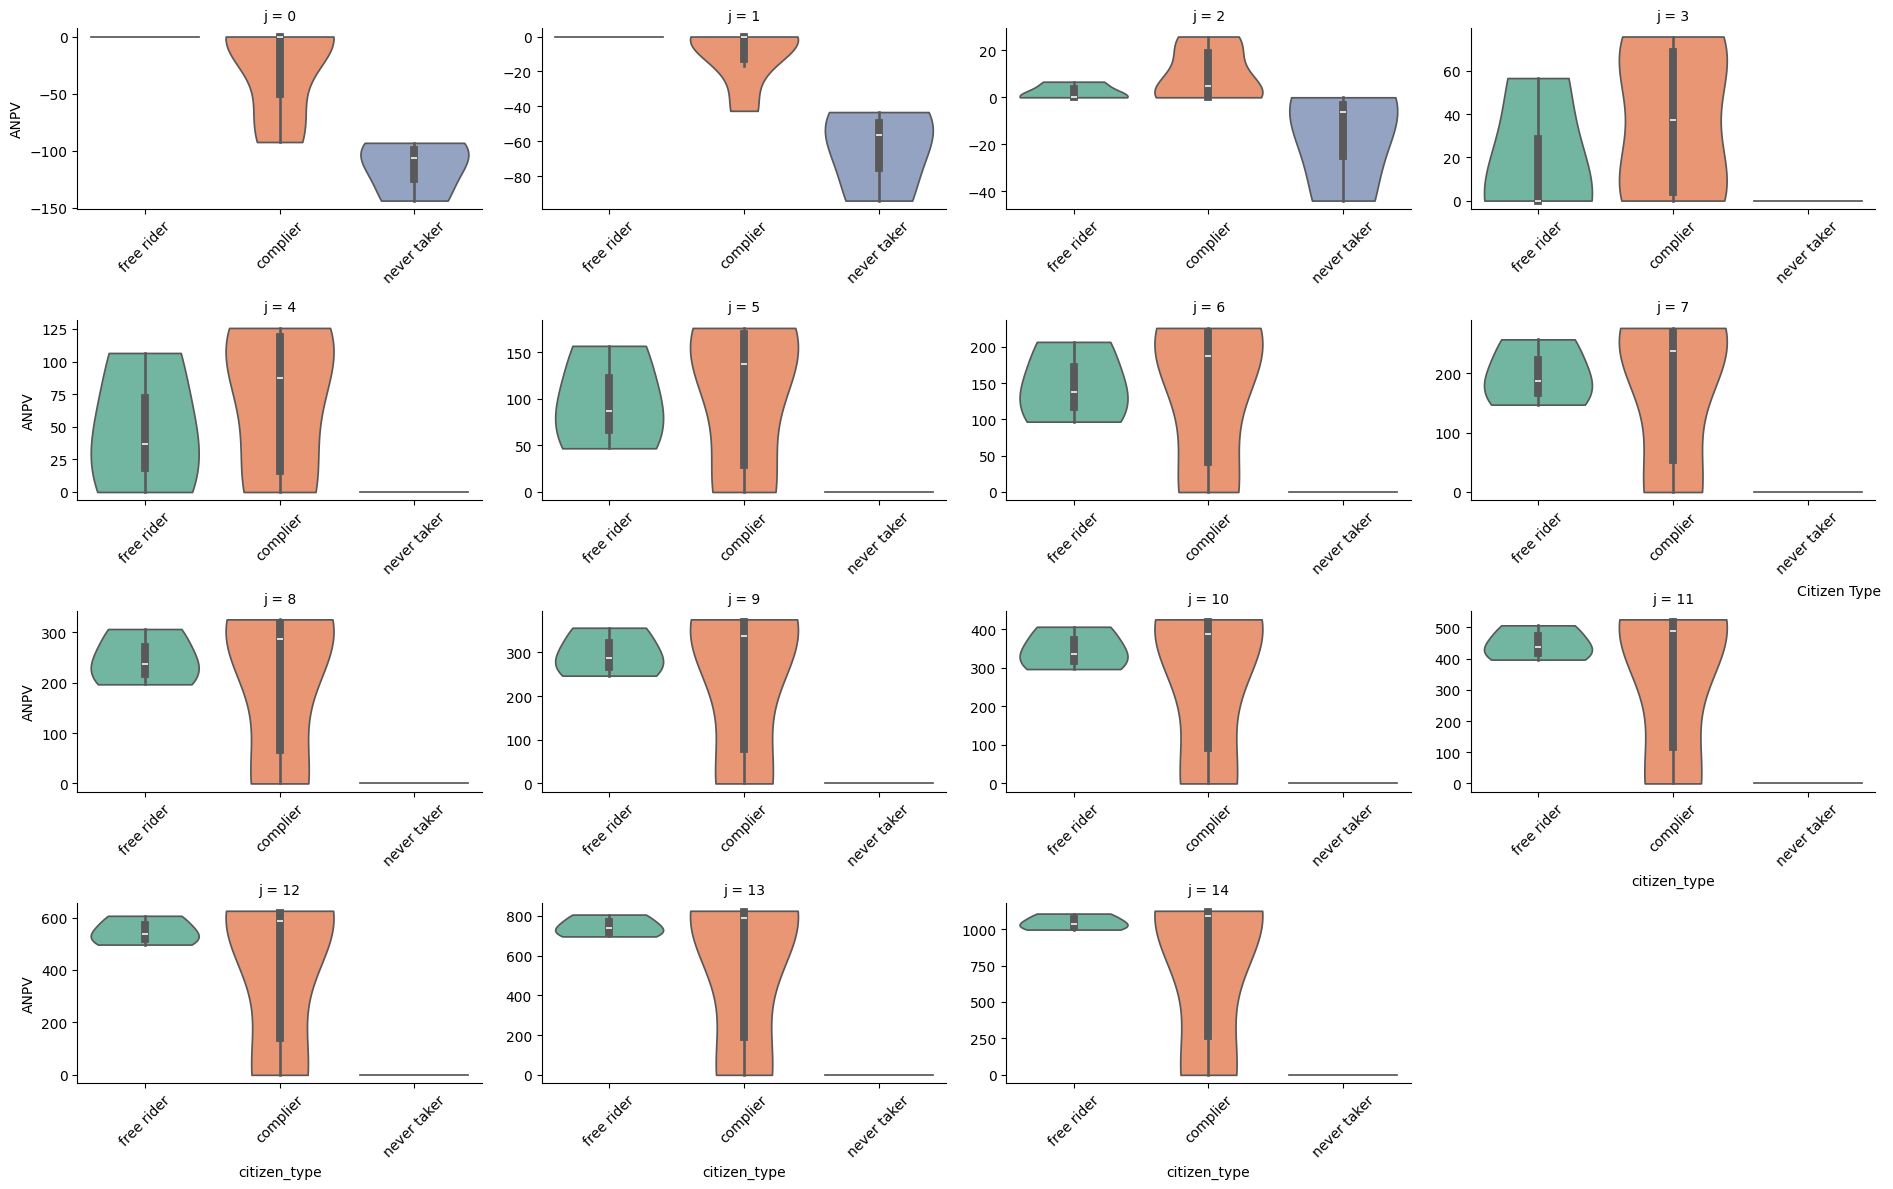

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     43.08
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           3.97e-25
Time:                        21:16:38   Log-Likelihood:                -193.72
No. Observations:                 180   AIC:                             397.4
Df Residuals:                     175   BIC:                             413.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [416]:
# Interest rate averaged over values of all 2021 months with a financial provision for your renovation is expected to have a residual maturity of, say, 10 years, you would look at the column labeled "WX0032 BBSDI:M:ABZINS7:R10," which represents the 7-year average rate for a residual maturity of 10 years.
# https://www.bundesbank.de/en/statistics/money-and-capital-markets/interest-rates-and-yields/discount-interest-rates/discount-interest-rates-793604
dependent_variable = 'ANPV'
independent_variables = ['is_nature_protector']
calculator = DeltaNVP(discount_rate=1.128)
key_ids = df_synthetic_3_5_n_emotional_0_1['key'].unique()
df_sample_sel = df_sample[(df_sample['citizen_type']!='unknown') & (df_sample['key'].isin(key_ids))][['key','citizen_type']+socioeconomic_factors+psychological_factors+npv_factors]
df_relevant = df_synthetic_3_5_n_emotional_0_1[['key']+final_columns].merge(df_sample_sel, on='key')
result_df = calculator.calculate_deltas(df_relevant, opportunity_cost, final_columns)
summary, merged_df_n_emo_gpt35 = calculator.model_delta_nvp(result_df, df_relevant, dependent_variable, independent_variables)
print(summary)


### Visualization of probabilities

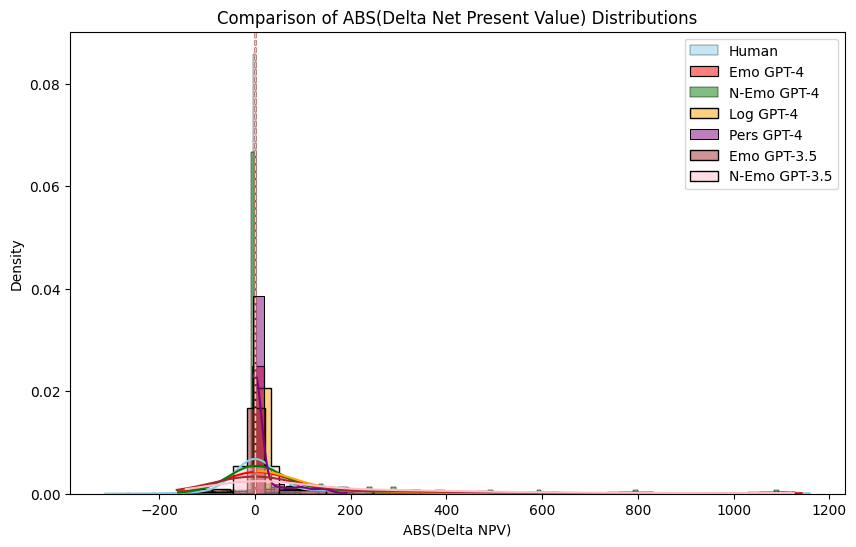

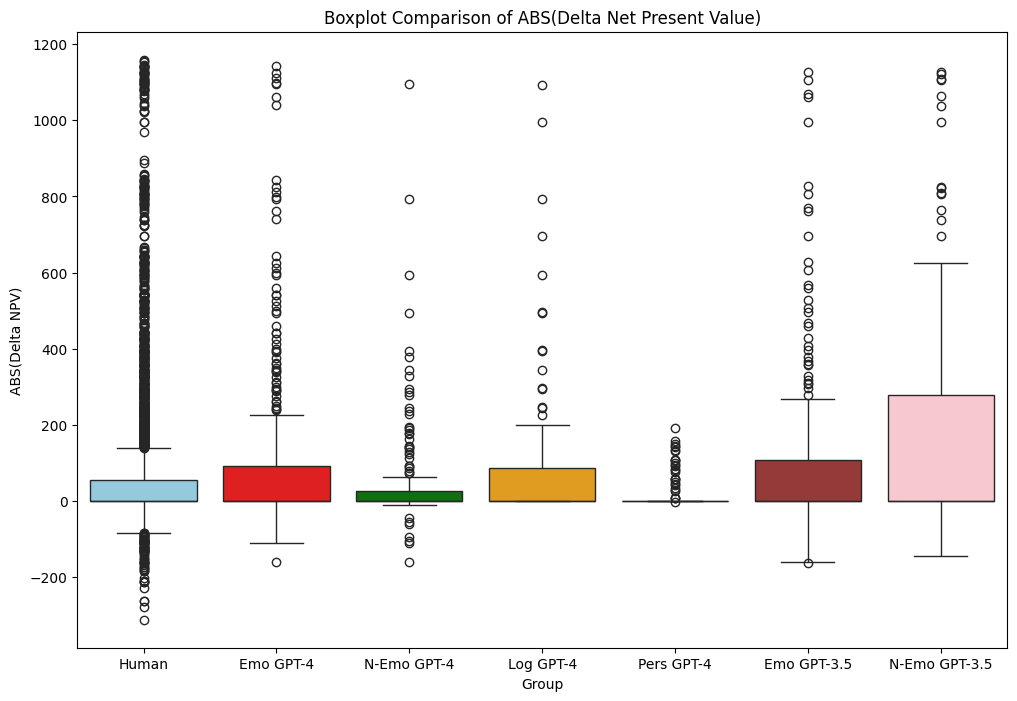

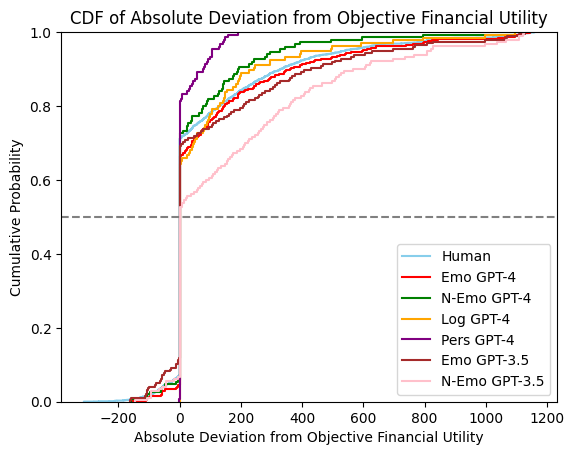

In [417]:
# Are humans more likely to deviate from the objective financial solution?
# HISTOGRAM
plt.figure(figsize=(10, 6))

# Histograms for each dataframe
sns.histplot(merged_df_human['ANPV'], color="skyblue", label='Human', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_emo_gpt4['ANPV'], color="red", label='Emo GPT-4', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_n_emo_gpt4['ANPV'], color="green", label='N-Emo GPT-4', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_log_gpt4['ANPV'], color="orange", label='Log GPT-4', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_pers_gpt4['ANPV'], color="purple", label='Pers GPT-4', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_emo_gpt35['ANPV'], color="brown", label='Emo GPT-3.5', kde=True, stat="density", alpha=0.5)
sns.histplot(merged_df_n_emo_gpt35['ANPV'], color="pink", label='N-Emo GPT-3.5', kde=True, stat="density", alpha=0.5)

# Add mean (or median) lines for each distribution
plt.axvline(merged_df_human['ANPV'].median(), color="skyblue", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_emo_gpt4['ANPV'].median(), color="red", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_n_emo_gpt4['ANPV'].median(), color="green", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_log_gpt4['ANPV'].median(), color="orange", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_pers_gpt4['ANPV'].median(), color="purple", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_emo_gpt35['ANPV'].median(), color="brown", linestyle='dashed', linewidth=1)
plt.axvline(merged_df_n_emo_gpt35['ANPV'].median(), color="pink", linestyle='dashed', linewidth=1)

# Add legend and labels
plt.legend()
plt.xlabel('ABS(Delta NPV)')
plt.ylabel('Density')
plt.title('Comparison of ABS(Delta Net Present Value) Distributions')
plt.show()

# BOXPLOT
# Reset index (if needed) and select the 'ANPV' column from each DataFrame
df_merged_human_reset = merged_df_human['ANPV'].reset_index(drop=True)
merged_df_emo_gpt4_reset = merged_df_emo_gpt4['ANPV'].reset_index(drop=True)
merged_df_n_emo_gpt4_reset = merged_df_n_emo_gpt4['ANPV'].reset_index(drop=True)
merged_df_log_gpt4_reset = merged_df_log_gpt4['ANPV'].reset_index(drop=True)
merged_df_pers_gpt4_reset = merged_df_pers_gpt4['ANPV'].reset_index(drop=True)
merged_df_emo_gpt35_reset = merged_df_emo_gpt35['ANPV'].reset_index(drop=True)
merged_df_n_emo_gpt35_reset = merged_df_n_emo_gpt35['ANPV'].reset_index(drop=True)

# Combine the data into a single DataFrame for plotting
data_to_plot = pd.concat([df_merged_human_reset, 
                          merged_df_emo_gpt4_reset, 
                          merged_df_n_emo_gpt4_reset,
                          merged_df_log_gpt4_reset,
                          merged_df_pers_gpt4_reset,
                          merged_df_emo_gpt35_reset,
                          merged_df_n_emo_gpt35_reset], 
                         axis=1, 
                         keys=['Human', 'Emo GPT-4', 'N-Emo GPT-4', 'Log GPT-4', 'Pers GPT-4', 'Emo GPT-3.5', 'N-Emo GPT-3.5'])

# Melt the data for seaborn boxplot
data_long_form = data_to_plot.melt(var_name='Group', value_name='ANPV')

# Define specific colors for each group
group_colors = ["skyblue", "red", "green", "orange", "purple", "brown", "pink"]

# Plot the boxplot with specified colors
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_long_form, x='Group', y='ANPV', palette=group_colors)
plt.xlabel('Group')
plt.ylabel('ABS(Delta NPV)')
plt.title('Boxplot Comparison of ABS(Delta Net Present Value)')
plt.show()

# CALCULATE CDF
# Plot the CDFs for each dataframe
sns.ecdfplot(merged_df_human['ANPV'], label='Human', color="skyblue")
sns.ecdfplot(merged_df_emo_gpt4['ANPV'], label='Emo GPT-4', color="red")
sns.ecdfplot(merged_df_n_emo_gpt4['ANPV'], label='N-Emo GPT-4', color="green")
sns.ecdfplot(merged_df_log_gpt4['ANPV'], label='Log GPT-4', color="orange")
sns.ecdfplot(merged_df_pers_gpt4['ANPV'], label='Pers GPT-4', color="purple")
sns.ecdfplot(merged_df_emo_gpt35['ANPV'], label='Emo GPT-3.5', color="brown")
sns.ecdfplot(merged_df_n_emo_gpt35['ANPV'], label='N-Emo GPT-3.5', color="pink")

# Add a horizontal line at y=0.5 (median) for reference
plt.axhline(y=0.5, color='gray', linestyle='--')

# Add labels and title
plt.xlabel('Absolute Deviation from Objective Financial Utility')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Absolute Deviation from Objective Financial Utility')
plt.legend()

# Show the plot
plt.show()

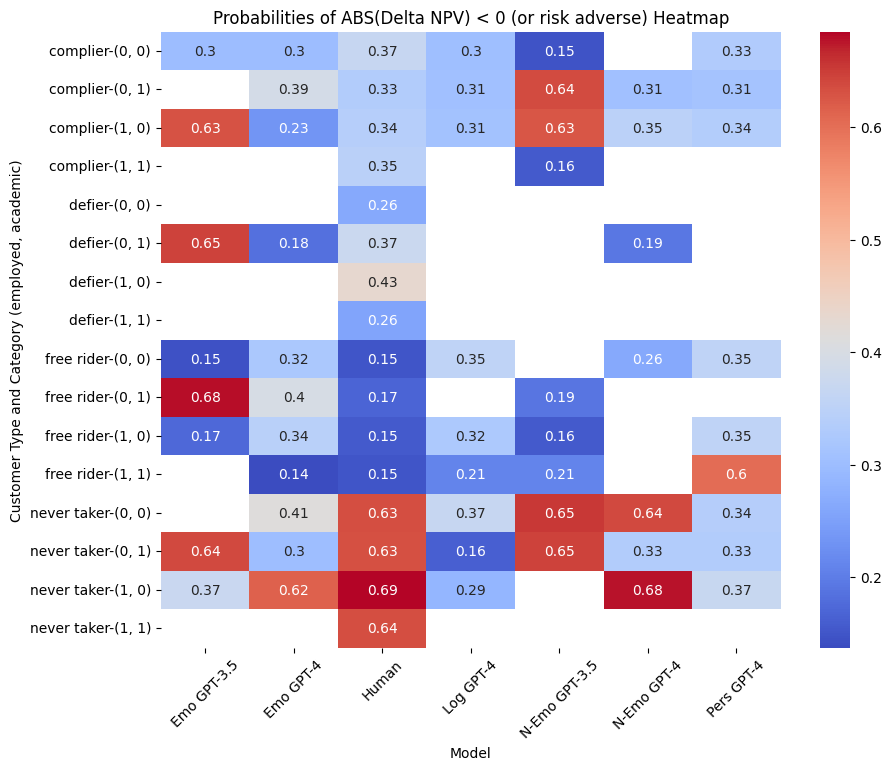

In [419]:
def calculate_conditional_probabilities(data, metric, category1, category2, value):
    results = {}
    for cat1 in data[category1].unique():
        for cat2 in data[category2].unique():
            subset = data[(data[category1] == cat1) & (data[category2] == cat2)]
            mean, std = subset[metric].mean(), subset[metric].std()

            # Assuming a normal distribution
            prob_distribution = norm(mean, std)

            # Probability of metric being less than a specific value
            prob = prob_distribution.cdf(value)
            results[(cat1, cat2)] = prob

    return results

# CALCULATION OF PROBABILITIES
# Prepare dataframes: add 'is_employed' and 'is_academic' columns
dataframes = [merged_df_human, merged_df_emo_gpt4, merged_df_n_emo_gpt4, merged_df_log_gpt4, merged_df_pers_gpt4, merged_df_emo_gpt35, merged_df_n_emo_gpt35]
dataframes = [df.reset_index() for df in dataframes]

for df in dataframes:
    df['is_employed'] = np.where(df['prof_status'] == 'employed', 1, 0)
    df['is_academic'] = np.where(df['high_education_level'] == 'academic', 1, 0)

# Reset index for each DataFrame
dataframes = [df.reset_index(drop=True) for df in dataframes]

# Calculate probabilities for each group and each dataframe
probabilities = []
citizen_types = ['complier', 'never taker', 'free rider', 'defier']
model_names = ['Human', 'Emo GPT-4', 'N-Emo GPT-4', 'Log GPT-4', 'Pers GPT-4', 'Emo GPT-3.5', 'N-Emo GPT-3.5']

for type in citizen_types:
    for df, model_name in zip(dataframes, model_names):
        key_ids = df[df['citizen_type'] == type]['key'].unique().tolist()
        conditional_probs = calculate_conditional_probabilities(df[df['key'].isin(key_ids)], 'ANPV', 'is_employed', 'is_academic', 0)

        for category, prob in conditional_probs.items():
            probabilities.append({'type': type, 'model': model_name, 'category (employed, academic)': category, 'probability': prob})

df_probs = pd.DataFrame(probabilities)

# Create pivot table for heatmap
heatmap_data = df_probs.pivot_table(index=['type', 'category (employed, academic)'], columns='model', values='probability')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Probabilities of ABS(Delta NPV) < 0 (or risk adverse) Heatmap')
plt.ylabel('Customer Type and Category (employed, academic)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

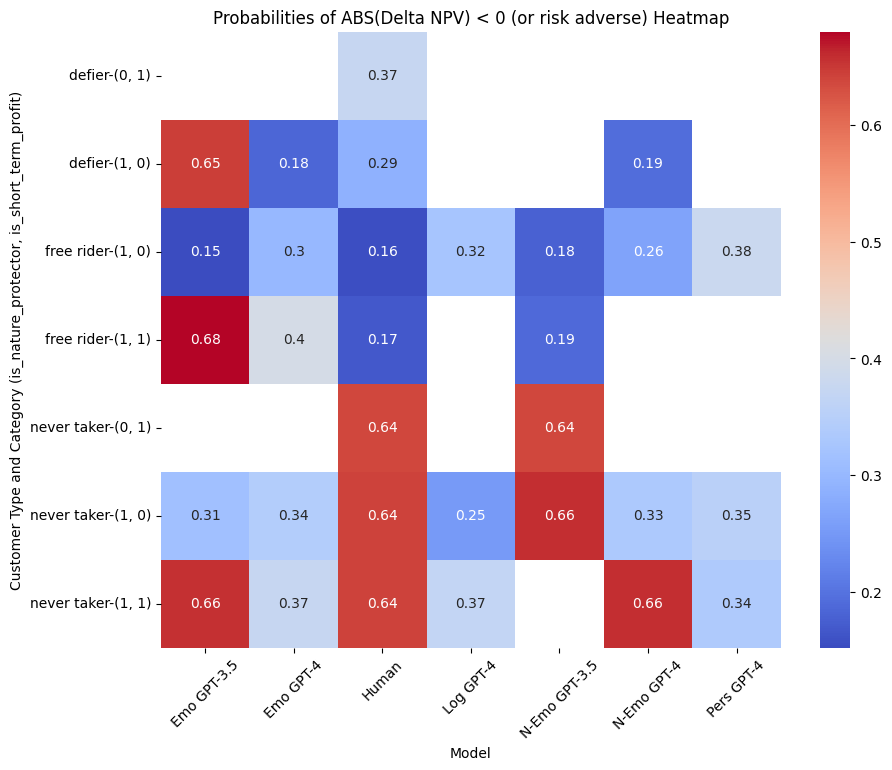

In [421]:
# CALCULATION OF PROBABILITIES
# Reset index for each new DataFrame and ensure the new categories are present
adjusted_dataframes = []
for df in [merged_df_human, merged_df_emo_gpt4, merged_df_n_emo_gpt4, merged_df_log_gpt4, merged_df_pers_gpt4, merged_df_emo_gpt35, merged_df_n_emo_gpt35]:
    # Reset index and ensure 'key' is a column
    if 'key' not in df.columns:
        df = df.reset_index().rename(columns={'index': 'key'})
    adjusted_dataframes.append(df)

probabilities_psyco = []
citizen_types = ['hard_complier', 'easy_complier', 'midle_complier', 'never taker', 'free rider', 'defier']
model_names = ['Human', 'Emo GPT-4', 'N-Emo GPT-4', 'Log GPT-4', 'Pers GPT-4', 'Emo GPT-3.5', 'N-Emo GPT-3.5']

for type in citizen_types:
    for df, model_name in zip(adjusted_dataframes, model_names):
        key_ids = df[df['citizen_type'] == type]['key'].unique().tolist()
        conditional_probs = calculate_conditional_probabilities(df[df['key'].isin(key_ids)], 'ANPV', 'is_nature_protector', 'is_short_term_profit', 0)

        for category, prob in conditional_probs.items():
            probabilities_psyco.append({'type': type, 'model': model_name, 'category (is_nature_protector, is_short_term_profit)': category, 'probability': prob})

# Convert probabilities to DataFrame
df_probs_psyco = pd.DataFrame(probabilities_psyco)

# Create pivot table for heatmap
heatmap_data = df_probs_psyco.pivot_table(index=['type', 'category (is_nature_protector, is_short_term_profit)'], columns='model', values='probability')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Probabilities of ABS(Delta NPV) < 0 (or risk adverse) Heatmap')
plt.ylabel('Customer Type and Category (is_nature_protector, is_short_term_profit)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()